In [4]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import chisquare
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from scipy import interp
from sklearn.metrics import confusion_matrix

In [5]:
data = pd.read_csv("34933-0001-Data.tsv", sep = '\t')

In [6]:
var = ['MJEVER','CADRLAST', 'IRHHSIZ2', 'IRKI17_2', 'IRHH65_2', 'IMOTHER', 'IFATHER', 
       'GOVTPROG', 'INCOME', 'YMDELT', 'YSDSOVRL', 'ANYHLTI2', 'CATAG7', 'HEALTH2', 
       'IRSEX', 'NEWRACE2', 'MOVESPY2', 'SCHENRL', 'SCHDSICK', 'SCHDSKIP'
       ,'WRKHAVJB','YESCHFLT','YELSTGRD', 'YEYFGTSW', 'YEYARGUP', 'YEPMJEVR', 'YEPRBSLV','YEDERGLR', 
        'YUMHCRYR', 'YUTPSTYR', 'YUSCEMYR']

## data preprocess
missing value: 

  legitimate skip: chisquare test with mode group.
  
  others: mean or mode.

In [7]:
data = data.loc[data['CATAG7']<4, var]
# MJEVER 1.yes 2.no
data = data.loc[data['MJEVER']<3]

In [8]:
len(data.loc[data['MJEVER']==1])

3102

In [9]:
len(data.loc[data['MJEVER']==2])

14283

In [10]:
#drink time in past 30 days 0-30
data.loc[data['CADRLAST']==991, 'CADRLAST'] = 0 #never used alcohol
data.loc[data['CADRLAST']==993, 'CADRLAST'] = 0 #did not use alcohol in past 30
data.loc[data['CADRLAST']==985, 'CADRLAST'] = np.nan # bad data
data.loc[data['CADRLAST']==994, 'CADRLAST'] = np.nan #dont know 
data.loc[data['CADRLAST']==997, 'CADRLAST'] = np.nan #refused
data.loc[data['CADRLAST']==998, 'CADRLAST'] = np.nan #blank
data['CADRLAST'] = data['CADRLAST'].fillna(data['CADRLAST'].mean()) #all filled with mean

In [11]:
# don't know whether father/mother is in household
#1.yes 2.no
data.loc[data['IMOTHER']==3, 'IMOTHER'] = np.nan # dont know
data.loc[data['IFATHER']==3, 'IFATHER'] = np.nan
data['IMOTHER'] = data['IMOTHER'].fillna(data['IMOTHER'].mode().loc[0])
data['IFATHER'] = data['IFATHER'].fillna(data['IFATHER'].mode().loc[0])

In [12]:
# lifetime major depressiove episode
# 1.yes 2.no
data.loc[data['YMDELT']==-9, 'YMDELT'] = np.nan # UNKNOWN
data['YMDELT'] = data['YMDELT'].fillna(data['YMDELT'].mode().loc[0])

In [13]:
# severity level of med role impairment
#1.none 2.mild 3.moderate 4. severe 5.very severe
data.loc[data['YSDSOVRL']==-9, 'YSDSOVRL'] = 1 #unkown
data['YSDSOVRL'] = data['YSDSOVRL'].fillna(data['YSDSOVRL'].mode().loc[0])

In [14]:
#covered by any health insurance 1.yes 2.no
data.loc[data['ANYHLTI2']==94, 'ANYHLTI2'] = np.nan #dont know
data.loc[data['ANYHLTI2']==97, 'ANYHLTI2'] = np.nan #refused
data.loc[data['ANYHLTI2']==98, 'ANYHLTI2'] = np.nan #other missing (few)
data['ANYHLTI2'] = data['ANYHLTI2'].fillna(data['ANYHLTI2'].mode().loc[0])

In [15]:
# health condition 1.excellet 2.very good 3.good 4.fair
data.loc[data['HEALTH2']==-9, 'HEALTH2'] = np.nan #UNKNOWN
data['HEALTH2'] = data['HEALTH2'].fillna(data['HEALTH2'].mode().loc[0])

In [16]:
# time moved past 12 month 0,1,2,3
data.loc[data['MOVESPY2']==994, 'MOVESPY2'] = np.nan
data.loc[data['MOVESPY2']==997, 'MOVESPY2'] = np.nan
data.loc[data['MOVESPY2']==998, 'MOVESPY2'] = np.nan
data['MOVESPY2'] = data['MOVESPY2'].fillna(data['MOVESPY2'].mode().loc[0])

In [17]:
#now enrolled in any school 1.yes 2.no
data.loc[data['SCHENRL']==11, 'SCHENRL'] = 1

In [18]:
# miss school from sick 0-30
data.loc[data['SCHDSICK']==90, 'SCHDSICK'] = np.nan
data.loc[data['SCHDSICK']==94, 'SCHDSICK'] = np.nan
data.loc[data['SCHDSICK']==97, 'SCHDSICK'] = np.nan
data.loc[data['SCHDSICK']==98, 'SCHDSICK'] = np.nan
data.loc[data['SCHDSICK']==99, 'SCHDSICK'] = np.nan
data['SCHDSICK'] = data['SCHDSICK'].fillna(data['SCHDSICK'].mean())

In [19]:
# miss school because of skipping 0-30
data.loc[data['SCHDSKIP']==94, 'SCHDSKIP'] = np.nan
data.loc[data['SCHDSKIP']==97, 'SCHDSKIP'] = np.nan
data.loc[data['SCHDSKIP']==98, 'SCHDSKIP'] = np.nan
data.loc[data['SCHDSKIP']==99, 'SCHDSKIP'] = np.nan
data['SCHDSKIP'] = data['SCHDSKIP'].fillna(data['SCHDSKIP'].mean())

In [20]:
a = 1831
b = 4862
c = 1096
d = 9007
a_e = (a+c)*(a+b)/(a+b+c+d)
b_e = a+b-a_e
c_e = (a+c)*(c+d)/(a+b+c+d)
d_e = c+d-c_e
chisquare([a,b,c,d], f_exp=[a_e,b_e,c_e,d_e])

Power_divergenceResult(statistic=762.4892488416051, pvalue=5.904576324166457e-165)

In [21]:
# whether have a job 1.yes 2.no 99. legitimate skip
data.loc[data['WRKHAVJB']==99, 'WRKHAVJB'] = 99
data.loc[data['WRKHAVJB']==94, 'WRKHAVJB'] = 2
data.loc[data['WRKHAVJB']==97, 'WRKHAVJB'] = 2
data.loc[data['WRKHAVJB']==98, 'WRKHAVJB'] = 2

In [22]:
a = 1366
b = 6650
c = 84
d = 832
a_e = (a+c)*(a+b)/(a+b+c+d)
b_e = a+b-a_e
c_e = (a+c)*(c+d)/(a+b+c+d)
d_e = c+d-c_e
chisquare([a,b,c,d], f_exp=[a_e,b_e,c_e,d_e])

Power_divergenceResult(statistic=37.44839861727411, pvalue=3.6983240558289796e-08)

In [23]:
# like to go to school 1.like a lot 2.kind of like 
# 3.didn't like 4.hate
data.loc[data['YESCHFLT']==85, 'YESCHFLT'] = 2 #bad data
data.loc[data['YESCHFLT']==94, 'YESCHFLT'] = 2 #dont known
data.loc[data['YESCHFLT']==97, 'YESCHFLT'] = 2 #refused
data.loc[data['YESCHFLT']==98, 'YESCHFLT'] = 2 #blank
data.loc[data['YESCHFLT']==99, 'YESCHFLT'] = 99 #legitmate skip

In [24]:
a = 1146
b = 5416
c = 84
d = 832
a_e = (a+c)*(a+b)/(a+b+c+d)
b_e = a+b-a_e
c_e = (a+c)*(c+d)/(a+b+c+d)
d_e = c+d-c_e
chisquare([a,b,c,d], f_exp=[a_e,b_e,c_e,d_e])

Power_divergenceResult(statistic=40.23340046853304, pvalue=9.507788739689339e-09)

In [25]:
# GPA 1.A 2.B 3.C 4.D
data.loc[data['YELSTGRD']==5, 'YELSTGRD'] = 2 #don't give these grads
data.loc[data['YELSTGRD']==85, 'YELSTGRD'] = 2 #bad data
data.loc[data['YELSTGRD']==94, 'YELSTGRD'] = 2 #dont know
data.loc[data['YELSTGRD']==97, 'YELSTGRD'] = 2 #refused
data.loc[data['YELSTGRD']==98, 'YELSTGRD'] = 2 #blank
data.loc[data['YELSTGRD']==99, 'YELSTGRD'] = 99 #legitomate skip

In [26]:
# serious fight 1.0 2.1-2 3.3-5 4.6-9 5.>10
data.loc[data['YEYFGTSW']==85, 'YEYFGTSW'] = np.nan #BAD DATA
data.loc[data['YEYFGTSW']==94, 'YEYFGTSW'] = np.nan #dont know
data.loc[data['YEYFGTSW']==97, 'YEYFGTSW'] = np.nan #refused
data['YEYFGTSW'] = data['YEYFGTSW'].fillna(data['YEYFGTSW'].mode().loc[0])

In [27]:
# fight with parents 1.0 2.1-2 3.3-5 4.6-9 5.>10
data.loc[data['YEYARGUP']==85, 'YEYARGUP'] = np.nan #bad data
data.loc[data['YEYARGUP']==94, 'YEYARGUP'] = np.nan #dont know
data.loc[data['YEYARGUP']==97, 'YEYARGUP'] = np.nan #refused
data['YEYARGUP'] = data['YEYARGUP'].fillna(data['YEYARGUP'].mode().loc[0])

In [28]:
# parent attitude 1.whatever 2.somewhat dsiapprove 3.stongly disapprove
data.loc[data['YEPMJEVR']==85, 'YEPMJEVR'] = np.nan #bad data
data.loc[data['YEPMJEVR']==94, 'YEPMJEVR'] = np.nan # dont know
data.loc[data['YEPMJEVR']==97, 'YEPMJEVR'] = np.nan #refused
data['YEPMJEVR'] = data['YEPMJEVR'].fillna(data['YEPMJEVR'].mode().loc[0])

In [29]:
# communication group 1.yes 2.no
data.loc[data['YEPRBSLV']==85, 'YEPRBSLV'] = np.nan #bad data
data.loc[data['YEPRBSLV']==94, 'YEPRBSLV'] = np.nan #dont know
data.loc[data['YEPRBSLV']==97, 'YEPRBSLV'] = np.nan #refused
data['YEPRBSLV'] = data['YEPRBSLV'].fillna(data['YEPRBSLV'].mode().loc[0])

In [30]:
a = 1771
b = 8825
c = 84
d = 832
a_e = (a+c)*(a+b)/(a+b+c+d)
b_e = a+b-a_e
c_e = (a+c)*(c+d)/(a+b+c+d)
d_e = c+d-c_e
chisquare([a,b,c,d], f_exp=[a_e,b_e,c_e,d_e])

Power_divergenceResult(statistic=35.4938774188028, pvalue=9.580217794171002e-08)

In [31]:
#info about drug 1.yes 2.no
data.loc[data['YEDERGLR']==85, 'YEDERGLR'] = 1 #bad data
data.loc[data['YEDERGLR']==94, 'YEDERGLR'] = 1 #dont know
data.loc[data['YEDERGLR']==97, 'YEDERGLR'] = 1 #refused
data.loc[data['YEDERGLR']==98, 'YEDERGLR'] = 1 #blank
data.loc[data['YEDERGLR']==99, 'YEDERGLR'] = 99 #legimate skip

In [32]:
#emotional problems 1.yes 2.no
data.loc[data['YUMHCRYR']==94, 'YUMHCRYR'] = np.nan  #dont know
data.loc[data['YUMHCRYR']==97, 'YUMHCRYR'] = np.nan  #refused
data.loc[data['YUMHCRYR']==85, 'YUMHCRYR'] = np.nan  #bad data
data['YUMHCRYR'] = data['YUMHCRYR'].fillna(data['YUMHCRYR'].mode().loc[0])

In [33]:
# trt for emotional problem 1.yes 2.no
data.loc[data['YUTPSTYR']==94, 'YUTPSTYR'] = np.nan #dont know
data.loc[data['YUTPSTYR']==97, 'YUTPSTYR'] = np.nan #refused 
data.loc[data['YUTPSTYR']==85, 'YUTPSTYR'] = np.nan #bad data
data['YUTPSTYR'] = data['YUTPSTYR'].fillna(data['YUTPSTYR'].mode().loc[0])

In [34]:
a = 2821
b = 12765
c = 92
d = 904
a_e = (a+c)*(a+b)/(a+b+c+d)
b_e = a+b-a_e
c_e = (a+c)*(c+d)/(a+b+c+d)
d_e = c+d-c_e
chisquare([a,b,c,d], f_exp=[a_e,b_e,c_e,d_e])

Power_divergenceResult(statistic=50.77837609363921, pvalue=5.453916913829806e-11)

In [35]:
# attend emotional problem school 1.yes 2.no
data.loc[data['YUSCEMYR']==85, 'YUSCEMYR'] = 2
data.loc[data['YUSCEMYR']==89, 'YUSCEMYR'] = 2
data.loc[data['YUSCEMYR']==94, 'YUSCEMYR'] = 2
data.loc[data['YUSCEMYR']==97, 'YUSCEMYR'] = 2
data.loc[data['YUSCEMYR']==98, 'YUSCEMYR'] = 2
data.loc[data['YUSCEMYR']==99, 'YUSCEMYR'] = 99

In [94]:
X = data.iloc[:,1:].values
y = data.iloc[:,0].values
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## baseline model 
withouth feature selection and upsampling

In [39]:
best_AUC = 0
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for p in ["l1", "l2"]:
    for c in [0.0001, 0.001, 0.1, 1, 10]:
        AUC = []
        for train_index, val_index in skf.split(X_t, y_t):
            X_train, X_val = X_t[train_index], X_t[val_index]
            y_train, y_val = y_t[train_index], y_t[val_index]
            transformer = Normalizer().fit(X_train)
            X_train = transformer.transform(X_train)
            X_val = transformer.transform(X_val)
            clf = LogisticRegression(random_state=0,solver='liblinear', penalty=p, C=c)
            #X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
            clf.fit(X_train, y_train)
            pred = clf.predict_proba(X_val)[:,1]
            fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
            AUC.append(metrics.auc(fpr, tpr))
        if np.mean(AUC)>best_AUC:
            best_AUC = np.mean(AUC)
            best_p = p
            best_C = c

In [40]:
best_AUC = 0
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for p in ["l1"]:
    for c in [0.7, 0.8, 0.9, 1, 1.1, 1.2]:
        AUC = []
        for train_index, val_index in skf.split(X_t, y_t):
            X_train, X_val = X_t[train_index], X_t[val_index]
            y_train, y_val = y_t[train_index], y_t[val_index]
            transformer = Normalizer().fit(X_train)
            X_train = transformer.transform(X_train)
            X_val = transformer.transform(X_val)
            clf = LogisticRegression(random_state=0,solver='liblinear', penalty=p, C=c)
            #X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
            clf.fit(X_train, y_train)
            pred = clf.predict_proba(X_val)[:,1]
            fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
            AUC.append(metrics.auc(fpr, tpr))
        if np.mean(AUC)>best_AUC:
            best_AUC = np.mean(AUC)
            best_p = p
            best_C = c

[[ 172  255]
 [  59 1949]]
[[ 187  240]
 [  68 1939]]
[[ 163  264]
 [  77 1930]]
[[ 179  247]
 [  72 1935]]
[[ 159  267]
 [  58 1949]]


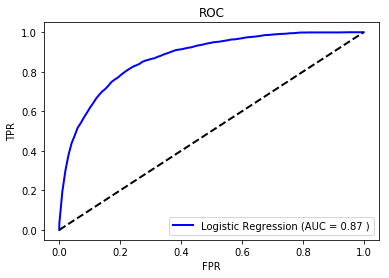

AUC: 0.8723277568087033
f1 score: 0.5166598763523363
Accuracy: 0.8679428314690554


In [61]:
import matplotlib.pyplot as plt
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
mean_fpr = np.linspace(0,1,100)
tprs = []
AUC = []
F = []
accuracy = []

for train_index, val_index in skf.split(X_t, y_t):
    X_train, X_val = X_t[train_index], X_t[val_index]
    y_train, y_val = y_t[train_index], y_t[val_index]
    transformer = Normalizer().fit(X_train)
    X_train = transformer.transform(X_train)
    X_val = transformer.transform(X_val)
    clf = LogisticRegression(random_state=0,solver='liblinear', penalty=best_p, C=best_C)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    clf.fit(X_train, y_train)
    pred = clf.predict_proba(X_val)[:,0]
    fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=1)
    tprs.append(interp(mean_fpr, fpr, tpr))
    AUC.append(metrics.auc(fpr, tpr))
    pred_val = clf.predict(X_val)
    F.append(metrics.f1_score(y_val, pred_val))
    accuracy.append(metrics.accuracy_score(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.concatenate([[0], mean_fpr])
mean_tpr = np.concatenate([[0], mean_tpr])
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label='Logistic Regression (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print("AUC: {}".format(np.mean(AUC)))
print("f1 score: {}".format(np.mean(F)))
print("Accuracy: {}".format(np.mean(accuracy)))

Automatically created module for IPython interactive environment
Normalized confusion matrix
[[0.77 0.23]
 [0.2  0.8 ]]


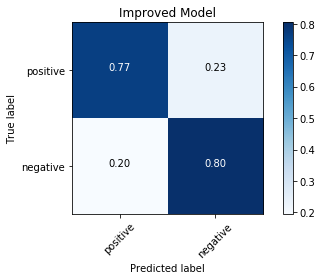

Normalized confusion matrix
[[0.4  0.6 ]
 [0.03 0.97]]


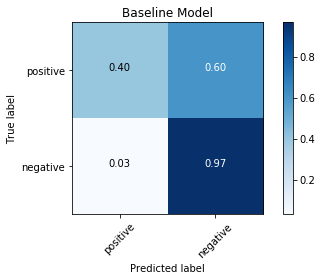

In [77]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with

class_names = ['positive', 'negative']

# Split the data into a training set and a test set



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Improved Model')

plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names, normalize=True,
                      title='Baseline Model')

plt.show()

## Naive Bayes
### cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.naive_bayes import ComplementNB

best_AUC = 0
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for norm in [True, False]:
    for alpha in [1e-10, 1.0, 2.0, 3.0]:
        print(norm, alpha)
        AUC = []
        for train_index, val_index in skf.split(X_t, y_t):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            cnb = ComplementNB(alpha=alpha, norm=norm)
            X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
            cnb.fit(X_resampled, y_resampled)
            pred = cnb.predict_proba(X_val)[:,1]
            fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
            AUC.append(metrics.auc(fpr, tpr))
        if np.mean(AUC)>best_AUC:
            print("Refreshed!")
            best_AUC = np.mean(AUC)
            best_norm = norm
            best_alpha = alpha

### evaluation

In [ ]:
import matplotlib.pyplot as plt
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
mean_fpr = np.linspace(0,1,100)
tprs = []
AUC = []
F = []
accuracy = []

for train_index, val_index in skf.split(X_t, y_t):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    cnb = ComplementNB(norm=best_norm, alpha=best_alpha)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    cnb.fit(X_resampled, y_resampled)
    pred = cnb.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
    tprs.append(interp(mean_fpr, fpr, tpr))
    AUC.append(metrics.auc(fpr, tpr))
    pred_val = cnb.predict(X_val)
    F.append(metrics.f1_score(y_val, pred_val))
    accuracy.append(metrics.accuracy_score(y_val, pred_val))
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.concatenate([[0], mean_fpr])
mean_tpr = np.concatenate([[0], mean_tpr])
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label='Complement Naive Bayes (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print("AUC: {}".format(np.mean(AUC)))
print("f1 score: {}".format(np.mean(F)))
print("Accuracy: {}".format(np.mean(accuracy)))

## Random Forest
### cross validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

best_AUC = 0
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for n_estimator in [100, 200, 300, 400, 500, 600]:
    for max_depth  in [6,8,10, 12, 15]:
        for min_samples_split  in [5e-3, 0.01, 0.015, 0.02]:    
            AUC = []
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                rf = RandomForestClassifier(random_state=0, n_estimators=n_estimator, max_depth=max_depth, min_samples_split=min_samples_split)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                rf.fit(X_resampled, y_resampled)
                pred = rf.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                best_AUC = np.mean(AUC)
                best_n_estimators = n_estimator
                best_max_depth = max_depth
                best_min_samples_split = min_samples_split

In [ ]:
for n_estimator in [600, 650, 700]:
    for max_depth  in [6,8,10, 12, 15]:
        for min_samples_split  in [5e-3, 0.01, 0.015, 0.02]:    
            AUC = []
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                rf = RandomForestClassifier(random_state=0, n_estimators=n_estimator, max_depth=max_depth, min_samples_split=min_samples_split)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                rf.fit(X_resampled, y_resampled)
                pred = rf.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                best_AUC = np.mean(AUC)
                best_n_estimators = n_estimator
                best_max_depth = max_depth
                best_min_samples_split = min_samples_split

### evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
mean_fpr = np.linspace(0,1,100)
tprs = []
AUC = []
F = []
accuracy = []
best_n_estimators = 600
best_max_depth = 10
best_min_samples_split = 0.01

for train_index, val_index in skf.split(X_t, y_t):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    rf = RandomForestClassifier(random_state=0, n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    rf.fit(X_resampled, y_resampled)
    pred = rf.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
    tprs.append(interp(mean_fpr, fpr, tpr))
    AUC.append(metrics.auc(fpr, tpr))
    pred_val = rf.predict(X_val)
    F.append(metrics.f1_score(y_val, pred_val))
    accuracy.append(metrics.accuracy_score(y_val, pred_val))
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.concatenate([[0], mean_fpr])
mean_tpr = np.concatenate([[0], mean_tpr])
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label='Random Forest (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print("AUC: {}".format(np.mean(AUC)))
print("f1 score: {}".format(np.mean(F)))
print("Accuracy: {}".format(np.mean(accuracy)))

## XGBoost
### cross validation

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

#fix some parameters
learning_rate =0.01
gamma = 0.1
subsample = 0.8
colsample_bytree = 0.8

best_AUC = 0
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)

for n_estimator in [200, 300, 400, 500]:
    for max_depth  in [3, 5, 7, 9]:
        for min_child_weight  in [1, 3, 5, 7]:    
            AUC = []
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                xgb = XGBClassifier(learning_rate = learning_rate, n_estimators = n_estimator,max_depth = max_depth,min_child_weight = min_child_weight, \
                                    gamma =gamma, subsample = subsample, colsample_bytree = colsample_bytree)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                xgb.fit(X_resampled, y_resampled)
                pred = xgb.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                best_AUC = np.mean(AUC)
                best_n_estimators = n_estimator
                best_max_depth = max_depth
                best_min_child_weight = min_child_weight


In [ ]:
for n_estimator in [600, 700, 900]:
    for max_depth  in [3, 5, 7, 9]:
        for min_child_weight  in [1, 3, 5, 7]:    
            AUC = []
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                xgb = XGBClassifier(learning_rate = learning_rate, n_estimators = n_estimator,max_depth = max_depth,min_child_weight = min_child_weight, \
                                    gamma =gamma, subsample = subsample, colsample_bytree = colsample_bytree)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                xgb.fit(X_resampled, y_resampled)
                pred = xgb.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                best_AUC = np.mean(AUC)
                best_n_estimators = n_estimator
                best_max_depth = max_depth
                best_min_child_weight = min_child_weight

In [ ]:
for n_estimator in [1000, 1200, 1400]:
    for max_depth  in [2, 3, 5, 7]:
        for min_child_weight  in [5, 7, 9]:    
            AUC = []
            print(n_estimator, max_depth, min_child_weight)
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                xgb = XGBClassifier(learning_rate = learning_rate, n_estimators = n_estimator,max_depth = max_depth,min_child_weight = min_child_weight, \
                                    gamma =gamma, subsample = subsample, colsample_bytree = colsample_bytree)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                xgb.fit(X_resampled, y_resampled)
                pred = xgb.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                print("Resfreshed!")
                best_AUC = np.mean(AUC)
                best_n_estimators = n_estimator
                best_max_depth = max_depth
                best_min_child_weight = min_child_weight

In [ ]:
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for gamma in [0.05, 0.1, 0.15]:
    for subsample  in [0.4, 0.5, 0.6,0.7]:
        for colsample_bytree  in [0.4, 0.5, 0.6,0.7]:    
            AUC = []
            print(gamma, subsample, colsample_bytree)
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                xgb = XGBClassifier(learning_rate = learning_rate, n_estimators=best_n_estimators,max_depth = best_max_depth,min_child_weight = best_min_child_weight, \
                                    gamma =gamma, subsample = subsample, colsample_bytree = colsample_bytree)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                xgb.fit(X_resampled, y_resampled)
                pred = xgb.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                print("Refreshed!")
                best_AUC = np.mean(AUC)
                best_gamma = gamma
                best_subsample = subsample
                best_colsample_bytree = colsample_bytree

In [ ]:
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for gamma in [0.15, 0.2, 0.25]:
    for subsample  in [0.2, 0.3, 0.4]:
        for colsample_bytree  in [0.2, 0.3, 0.4]:    
            AUC = []
            print(gamma, subsample, colsample_bytree)
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                xgb = XGBClassifier(learning_rate = learning_rate, n_estimators=best_n_estimators,max_depth = best_max_depth,min_child_weight = best_min_child_weight, \
                                    gamma =gamma, subsample = subsample, colsample_bytree = colsample_bytree)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                xgb.fit(X_resampled, y_resampled)
                pred = xgb.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                print("Refreshed!")
                best_AUC = np.mean(AUC)
                best_gamma = gamma
                best_subsample = subsample
                best_colsample_bytree = colsample_bytree

In [ ]:
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for gamma in [0.1, 0.15]:
    for subsample  in [0.2, 0.3, 0.4]:
        for colsample_bytree  in [0.3, 0.4, 0.5]:    
            AUC = []
            print(gamma, subsample, colsample_bytree)
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                xgb = XGBClassifier(learning_rate = learning_rate, n_estimators=best_n_estimators,max_depth = best_max_depth,min_child_weight = best_min_child_weight, \
                                    gamma =gamma, subsample = subsample, colsample_bytree = colsample_bytree)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                xgb.fit(X_resampled, y_resampled)
                pred = xgb.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                print("Refreshed!")
                best_AUC = np.mean(AUC)
                best_gamma = gamma
                best_subsample = subsample
                best_colsample_bytree = colsample_bytree

In [ ]:
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for gamma in [0.1, 0.15]:
    for subsample  in [0.2, 0.3, 0.4]:
        for colsample_bytree  in [0.3, 0.4, 0.5]:    
            AUC = []
            print(gamma, subsample, colsample_bytree)
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                xgb = XGBClassifier(learning_rate = learning_rate, n_estimators=best_n_estimators,max_depth = best_max_depth,min_child_weight = best_min_child_weight, \
                                    gamma =gamma, subsample = subsample, colsample_bytree = colsample_bytree)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                xgb.fit(X_resampled, y_resampled)
                pred = xgb.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                print("Refreshed!")
                best_AUC = np.mean(AUC)
                best_gamma = gamma
                best_subsample = subsample
                best_colsample_bytree = colsample_bytree

### evaluation

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
mean_fpr = np.linspace(0,1,100)
tprs = []
AUC = []
F = []
accuracy = []

for train_index, val_index in skf.split(X_t, y_t):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    xgb = XGBClassifier(learning_rate = learning_rate, n_estimators=best_n_estimators,max_depth = best_max_depth,min_child_weight = best_min_child_weight, \
                                    gamma = best_gamma, subsample = best_subsample, colsample_bytree = best_colsample_bytree)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    xgb.fit(X_resampled, y_resampled)
    pred = xgb.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
    tprs.append(interp(mean_fpr, fpr, tpr))
    AUC.append(metrics.auc(fpr, tpr))
    pred_val = xgb.predict(X_val)
    F.append(metrics.f1_score(y_val, pred_val))
    accuracy.append(metrics.accuracy_score(y_val, pred_val))
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.concatenate([[0], mean_fpr])
mean_tpr = np.concatenate([[0], mean_tpr])
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label='XGBoost (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print("AUC: {}".format(np.mean(AUC)))
print("f1 score: {}".format(np.mean(F)))
print("Accuracy: {}".format(np.mean(accuracy)))

## GBDT
### cross validation

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

#fix some parameters
learning_rate =0.01
#n_estimator = 200
#subsample=0.8


best_AUC = 0
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)

for n_estimator in [200, 400, 600]:
    for max_depth  in [3, 5, 7, 9]:
        for min_samples_split  in [5, 25, 45]:    
            print(n_estimator, max_depth, min_samples_split)
            AUC = []
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                gbdt = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_estimator,max_depth = max_depth,min_samples_split = min_samples_split)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                gbdt.fit(X_resampled, y_resampled)
                pred = gbdt.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                print("Refreshed!")
                best_AUC = np.mean(AUC)
                best_n_estimators = n_estimator
                best_max_depth = max_depth
                best_min_samples_split = min_samples_split


In [ ]:
for n_estimator in [800, 1000, 1200]:
    for max_depth  in [1, 3, 5]:
        for min_samples_split  in [25, 45, 65]:    
            print(n_estimator, max_depth, min_samples_split)
            AUC = []
            for train_index, val_index in skf.split(X_t, y_t):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                gbdt = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_estimator,max_depth = max_depth,min_samples_split = min_samples_split)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                gbdt.fit(X_resampled, y_resampled)
                pred = gbdt.predict_proba(X_val)[:,1]
                fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
                AUC.append(metrics.auc(fpr, tpr))
            if np.mean(AUC)>best_AUC:
                print("Refreshed!")
                best_AUC = np.mean(AUC)
                best_n_estimators = n_estimator
                best_max_depth = max_depth
                best_min_samples_split = min_samples_split

### evaluation

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
mean_fpr = np.linspace(0,1,100)
tprs = []
AUC = []
F = []
accuracy = []

for train_index, val_index in skf.split(X_t, y_t):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    gbdt = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = best_n_estimators,max_depth = best_max_depth,min_samples_split = best_min_samples_split)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    gbdt.fit(X_resampled, y_resampled)
    pred = gbdt.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
    tprs.append(interp(mean_fpr, fpr, tpr))
    AUC.append(metrics.auc(fpr, tpr))
    pred_val = gbdt.predict(X_val)
    F.append(metrics.f1_score(y_val, pred_val))
    accuracy.append(metrics.accuracy_score(y_val, pred_val))
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.concatenate([[0], mean_fpr])
mean_tpr = np.concatenate([[0], mean_tpr])
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label='GBDT (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print("AUC: {}".format(np.mean(AUC)))
print("f1 score: {}".format(np.mean(F)))
print("Accuracy: {}".format(np.mean(accuracy)))

## Logistic Regression
### feature selection

In [95]:
from sklearn.feature_selection import chi2
p_val = chi2(X_t, y_t)[1]
var_select = np.array(var[1:])[p_val<0.05]
data_select = data.loc[:, var_select]
var_dum = ['WRKHAVJB','YESCHFLT','YELSTGRD','YEDERGLR','YUSCEMYR']
for i in var_dum:
    data_select = pd.merge(data_select, pd.get_dummies(data_select[i], prefix=i, drop_first=True), left_index = True, right_index =True) 
    data_select.drop(i, axis=1, inplace=True)
X = data_select.iloc[:,:].values
y = data.iloc[:,0].values
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### cross validation

In [41]:
best_AUC = 0
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for p in ["l1", "l2"]:
    for c in [0.0001, 0.001, 0.1, 1, 10]:
        AUC = []
        for train_index, val_index in skf.split(X_t, y_t):
            X_train, X_val = X_t[train_index], X_t[val_index]
            y_train, y_val = y_t[train_index], y_t[val_index]
            transformer = Normalizer().fit(X_train)
            X_train = transformer.transform(X_train)
            X_val = transformer.transform(X_val)
            clf = LogisticRegression(random_state=0,solver='liblinear', penalty=p, C=c)
            X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
            clf.fit(X_resampled, y_resampled)
            pred = clf.predict_proba(X_val)[:,0]
            fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=1)
            AUC.append(metrics.auc(fpr, tpr))
        if np.mean(AUC)>best_AUC:
            best_AUC = np.mean(AUC)
            best_p = p
            best_C = c

In [42]:
best_AUC = 0
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for p in ["l1"]:
    for c in [0.7, 0.8, 0.9, 1, 1.1, 1.2]:
        AUC = []
        for train_index, val_index in skf.split(X_t, y_t):
            X_train, X_val = X_t[train_index], X_t[val_index]
            y_train, y_val = y_t[train_index], y_t[val_index]
            transformer = Normalizer().fit(X_train)
            X_train = transformer.transform(X_train)
            X_val = transformer.transform(X_val)
            clf = LogisticRegression(random_state=0,solver='liblinear', penalty=p, C=c)
            X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
            clf.fit(X_resampled, y_resampled)
            pred = clf.predict_proba(X_val)[:,0]
            fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=1)
            AUC.append(metrics.auc(fpr, tpr))
        if np.mean(AUC)>best_AUC:
            best_AUC = np.mean(AUC)
            best_p = p
            best_C = c

## evaluation

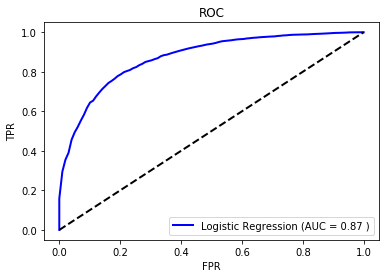

AUC: 0.8725978953197799
f1 score: 0.57879192061313
Accuracy: 0.8036823720129596


In [102]:
import matplotlib.pyplot as plt
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
mean_fpr = np.linspace(0,1,100)
tprs = []
AUC = []
F = []
accuracy = []

for train_index, val_index in skf.split(X_t, y_t):
    X_train, X_val = X_t[train_index], X_t[val_index]
    y_train, y_val = y_t[train_index], y_t[val_index]
    transformer = Normalizer().fit(X_train)
    X_train = transformer.transform(X_train)
    X_val = transformer.transform(X_val)
    clf = LogisticRegression(random_state=0,solver='liblinear', penalty=best_p, C=best_C)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    clf.fit(X_resampled, y_resampled)
    pred = clf.predict_proba(X_val)[:,0]
    fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=1)
    tprs.append(interp(mean_fpr, fpr, tpr))
    AUC.append(metrics.auc(fpr, tpr))
    pred_val = clf.predict(X_val)
    F.append(metrics.f1_score(y_val, pred_val))
    accuracy.append(metrics.accuracy_score(y_val, pred_val))
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.concatenate([[0], mean_fpr])
mean_tpr = np.concatenate([[0], mean_tpr])
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label='Logistic Regression (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print("AUC: {}".format(np.mean(AUC)))
print("f1 score: {}".format(np.mean(F)))
print("Accuracy: {}".format(np.mean(accuracy)))

In [41]:
GBDT_fpr = np.load("C:/Users/gong/Documents/learning/Intro. to DS/fpr_tpr/GBDT_fpr.pkl")
GBDT_tpr = np.load("C:/Users/gong/Documents/learning/Intro. to DS/fpr_tpr/GBDT_tpr.pkl")
NB_fpr = np.load("C:/Users/gong/Documents/learning/Intro. to DS/fpr_tpr/NaiveBayes_fpr.pkl")
NB_tpr = np.load("C:/Users/gong/Documents/learning/Intro. to DS/fpr_tpr/NaiveBayes_tpr.pkl")
RF_fpr = np.load("C:/Users/gong/Documents/learning/Intro. to DS/fpr_tpr/RadomForest_fpr.pkl")
RF_tpr = np.load("C:/Users/gong/Documents/learning/Intro. to DS/fpr_tpr/RadomForest_tpr.pkl")
XGB_fpr = np.load("C:/Users/gong/Documents/learning/Intro. to DS/fpr_tpr/XGBoost_fpr.pkl")
XGB_tpr = np.load("C:/Users/gong/Documents/learning/Intro. to DS/fpr_tpr/XGBoost_tpr.pkl")

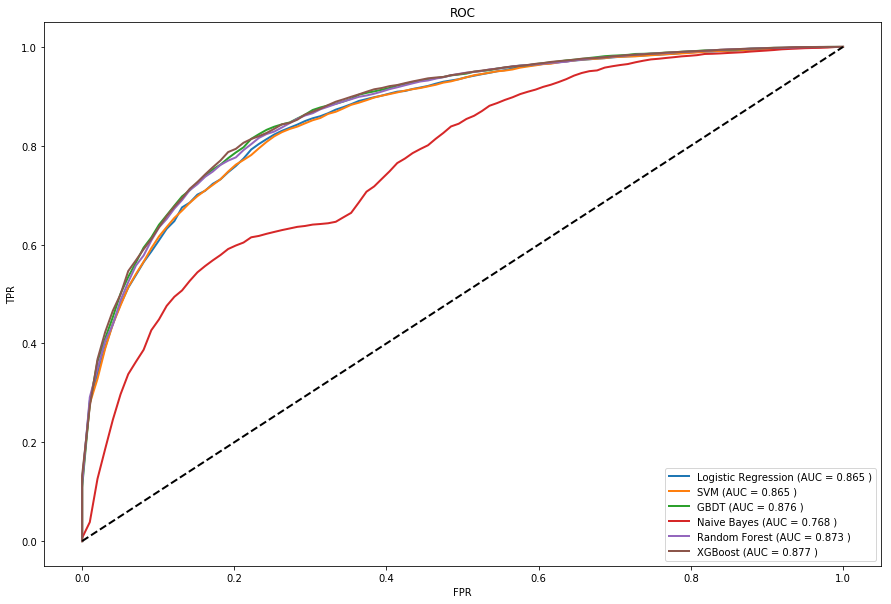

In [46]:
plt.figure(figsize=(15,10))
plt.plot(mean_fpr, mean_tpr,
         label='Logistic Regression (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)
plt.plot(svm_fpr, svm_tpr,
         label='SVM (AUC = %0.3f )' % ( metrics.auc(svm_fpr, svm_tpr)),lw=2, alpha=1)
plt.plot(GBDT_fpr, GBDT_tpr,
         label='GBDT (AUC = %0.3f )' % ( metrics.auc(GBDT_fpr, GBDT_tpr)),lw=2, alpha=1)
plt.plot(NB_fpr,NB_tpr,
         label='Naive Bayes (AUC = %0.3f )' % ( metrics.auc(NB_fpr, NB_tpr)),lw=2, alpha=1)
plt.plot(RF_fpr, RF_tpr,
         label='Random Forest (AUC = %0.3f )' % ( metrics.auc(RF_fpr, RF_tpr)),lw=2, alpha=1)
plt.plot(XGB_fpr, XGB_tpr,
         label='XGBoost (AUC = %0.3f )' % ( metrics.auc(XGB_fpr, XGB_tpr)),lw=2, alpha=1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig("roc.pdf")
plt.show()

## SVC
### feature selection

In [ ]:
from sklearn.feature_selection import chi2
p_val = chi2(X_t, y_t)[1]
var_select = np.array(var[1:])[p_val<0.05]
data_select = data.loc[:, var_select]
var_dum = ['WRKHAVJB','YESCHFLT','YELSTGRD','YEDERGLR','YUSCEMYR']
for i in var_dum:
    data_select = pd.merge(data_select, pd.get_dummies(data_select[i], prefix=i, drop_first=True), left_index = True, right_index =True) 
    data_select.drop(i, axis=1, inplace=True)
X = data_select.iloc[:,:].values
y = data.iloc[:,0].values
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### cross validation

In [234]:
from sklearn.svm import SVC

best_AUC = 0
ros = RandomOverSampler(random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
for k in ["rbf", "linear","sigmoid"]:
    for c in [0.0001, 0.001, 0.1, 1, 10]:
        AUC = []
        for train_index, val_index in skf.split(X_t, y_t):
            X_train, X_val = X_t[train_index], X_t[val_index]
            y_train, y_val = y_t[train_index], y_t[val_index]
            transformer = Normalizer().fit(X_train)
            X_train = transformer.transform(X_train)
            X_val = transformer.transform(X_val)
            clf = SVC(C=c, kernel=k, gamma="auto", probability=True)
            X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
            clf.fit(X_resampled, y_resampled)
            pred = clf.predict_proba(X_val)[:,1]
            fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=2)
            AUC.append(metrics.auc(fpr, tpr))
        if np.mean(AUC)>best_AUC:
            best_AUC = np.mean(AUC)
            best_k = k
            best_C = c

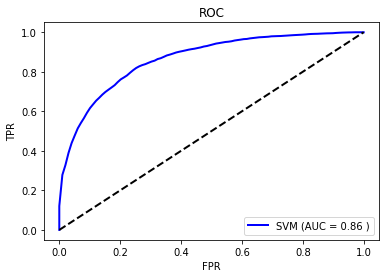

AUC: 0.8647201183897375
f1 score: 0.5725120241857633
Accuracy: 0.8008876036650697


In [238]:
skf = StratifiedKFold(n_splits=5, random_state=0)
skf.get_n_splits(X_t, y_t)
mean_fpr = np.linspace(0,1,100)
tprs = []
AUC = []
F = []
accuracy = []

for train_index, val_index in skf.split(X_t, y_t):
    X_train, X_val = X_t[train_index], X_t[val_index]
    y_train, y_val = y_t[train_index], y_t[val_index]
    transformer = Normalizer().fit(X_train)
    X_train = transformer.transform(X_train)
    X_val = transformer.transform(X_val)
    clf = SVC(C=best_C, kernel=best_k, gamma="auto", probability=True)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    clf.fit(X_resampled, y_resampled)
    pred = clf.predict_proba(X_val)[:,0]
    fpr, tpr, thresholds = metrics.roc_curve(y_val, pred, pos_label=1)
    tprs.append(interp(mean_fpr, fpr, tpr))
    AUC.append(metrics.auc(fpr, tpr))
    pred_val = clf.predict(X_val)
    F.append(metrics.f1_score(y_val, pred_val))
    accuracy.append(metrics.accuracy_score(y_val, pred_val))
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.concatenate([[0], mean_fpr])
mean_tpr = np.concatenate([[0], mean_tpr])
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label='SVM (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print("AUC: {}".format(np.mean(AUC)))
print("f1 score: {}".format(np.mean(F)))
print("Accuracy: {}".format(np.mean(accuracy)))

In [241]:
clf = SVC(C=best_C, kernel=best_k, gamma="auto", probability=True)
transformer = Normalizer().fit(X_t)
X_t = transformer.transform(X_t)
X_test = transformer.transform(X_test)
X_resampled, y_resampled = ros.fit_resample(X_t, y_t)
clf.fit(X_resampled, y_resampled)
pred = clf.predict_proba(X_test)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
pred_val = clf.predict(X_test)
print("AUC: {}".format(metrics.auc(fpr, tpr)))
print("f1 score: {}".format(metrics.f1_score(y_test, pred_val)))
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred_val)))
cnf_matrix = confusion_matrix(y_test, pred_val)
print(cnf_matrix)

AUC: 0.8647239124418062
f1 score: 0.5792349726775955
Accuracy: 0.7933282208588958
[[ 742  227]
 [ 851 3396]]


## Lime

In [127]:
categorical_features = [1,2,3,4,5,6,7,8,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]

In [128]:
import sklearn.preprocessing

categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(X[:, feature])
    X[:, feature] = le.transform(X[:, feature])
    categorical_names[feature] = le.classes_

In [103]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

ros = RandomOverSampler(random_state=0)
clf = LogisticRegression(random_state=0,solver='liblinear', penalty=best_p, C=best_C)
X_resampled, y_resampled = ros.fit_resample(X_t, y_t)
clf.fit(X_resampled, y_resampled)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [130]:
feature_names = data_select
class_names = ["yes","no"]
predict_fn = lambda x: clf.predict_proba(x).astype(float)

In [131]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_resampled,feature_names = feature_names,class_names=class_names,
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names, kernel_width=3)

In [132]:
np.random.seed(1)
i = 1051
exp = explainer.explain_instance(X_test[i], predict_fn, num_features=5)
exp.show_in_notebook(show_all=False)